In [1]:
from typing import List
import numpy as np
from genobs.experiment_parameters import *
from genobs.Rubidium87_operators import *
from genobs.visualizations import *
from qutip import *
from copy import copy
from lmfit.model import Model
import datetime
from pathlib import Path


mw_transition = 1  # MW transitions nr 1-9
bx, by = Bxy_from_mw_rabi_sigma_plus_minus(80.871301e3, 67.557761e3)  # from experiment
bz = Bz_from_rabi_pi_clock(74.693683e3)
b_longitudinal = 0.1
laser_intens = 0.01 * 10
doppler_FWHM = 0.56e9 * 2 * pi
sigma = doppler_FWHM / (2 * np.log(2)) ** 0.5 / 2
number_of_detunings = 41
laser_detunings = np.linspace(-1, 1, number_of_detunings) ** 3 * sigma * 4
# laser_detunings = np.linspace(left_interval, -left_interval, number_of_detunings)


In [2]:
def norm_dist(det):
    return 1/(sigma * (2*pi)**0.5) * np.exp(-0.5 * (det/sigma)**2)

def H_B(line="", bx=0, by=0, bz=0):
    hb = H_B_ground_uncoupled(bx=bx, by=by, bz=bz).transform(F_kets_in_I_J_basis())
    tmp = np.zeros((16, 16), dtype=np.cdouble)
    tmp[:8, :8] = hb.full()
    if bz != 0:
        tmp[8:, 8:] = H_Bz_excited_D1_IJ(bz=bz).transform(F_kets_in_I_J_basis()).full()
    return Qobj(tmp)


def hamil(
    mw_det,
    b_longitudinal=0.1,
    B_mw_vector=[0, 0, 0],
    laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL / 500,
    laser_detuning=0    # detuning from F=2, mF=0 --> F'=1, mF=0; we still assume laser doesn't drive F=1->F'
):
    ham_laser_atom = H_atom_field_D1(-1, E_0_plus(laser_intens)).full()
    ham_laser_atom[:3, :] = 0  # F=1 -> F' neglected
    ham_laser_atom[:, :3] = 0
    hb_ac = H_B("D1", bx=B_mw_vector[0], by=B_mw_vector[1], bz=B_mw_vector[2])
    hb_ac = hb_ac.full()
    for k in range(16):
        hb_ac[k, k] = 0.0  # rotating...
    hb_ac[8:, 8:] = 0.0
    h0 = H_atom(0, "D1") + H_B("D1", bz=b_longitudinal)
    # h0 = h0.full()
    h0 = np.diag(h0.diag())
    ham_tot = Qobj(h0) + Qobj(hb_ac) + Qobj(ham_laser_atom)
    temp = ham_tot.full()
    laser_freq = temp[9, 9] - temp[5, 5] + laser_detuning
    for k in range(8, 16):
        temp[k, k] -= laser_freq
    for k in range(3):
        temp[k, k] += mw_det  # rotating frame mw: level of F=1 shifted to F=2
    for i in range(15):  # RWA rf freqs
        temp[i, i + 1] = 0.0
        temp[i + 1, i] = 0.0
    en_offset = temp[5, 5]
    for i in range(16):
        temp[i, i] -= en_offset  # set |F=2, mF=0 > as zero energy
    return Qobj(temp)


decays = (
    natural_decay_ops_D1()
    + quenching_ops("D1")
    + wall_coll("D1", gamma=2e3)  # gamma chosen to roughly approx experiment
    + dephasing_excited_states("D1", gamma=1.6e8)
    # + dephasing_ground_states_D1()
)






ham_mw_off_list = [hamil(
    0,
    b_longitudinal=b_longitudinal,
    laser_intens=laser_intens,
    B_mw_vector=[0, 0, 0],
    laser_detuning=det
) for det in laser_detunings]
laser_ss_list = [steadystate(elem, c_op_list=decays) for elem in ham_mw_off_list]

ham_mw_off = ham_mw_off_list[0]
hyperfine_transition_freqs = [
    ham_mw_off[3, 3] - ham_mw_off[0, 0],  # MW sigma minus
    ham_mw_off[4, 4] - ham_mw_off[0, 0],  # pi 1
    ham_mw_off[4, 4] - ham_mw_off[1, 1],
    ham_mw_off[5, 5] - ham_mw_off[0, 0],  # double
    ham_mw_off[5, 5] - ham_mw_off[1, 1],  # pi clock
    ham_mw_off[5, 5] - ham_mw_off[2, 2],
    ham_mw_off[6, 6] - ham_mw_off[1, 1],  # double
    ham_mw_off[6, 6] - ham_mw_off[2, 2],
    ham_mw_off[7, 7] - ham_mw_off[2, 2],
]

mw_detuning= hyperfine_transition_freqs[mw_transition-1]
hs = [hamil(
        mw_detuning, b_longitudinal, laser_intens=laser_intens, B_mw_vector=[bx, by, bz], laser_detuning=det
    )
for det in laser_detunings]

parallel_fun_input = list(zip(hs, [laser_ss for laser_ss in laser_ss_list], [decays for _ in hs]))

parameters = {
    "Static Bz": b_longitudinal,
    "MW transition": mw_transition,
    "MW detunings": mw_detuning,
    "MW magnetic field X": bx,
    "MW magnetic field Y": by,
    "MW magnetic field Z": bz,
    "Laser detunings": laser_detunings,
    "Doppler FWHM": doppler_FWHM,
    "Laser intensity": laser_intens,
    "Laser polarization": "Sigma Plus",
}
    

# %pwd 

# %cd '/scicore/home/treutlei/vogmic00/blochsim/mw double resonance time evo'



qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman and Simon Cross.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.0
Numpy Version:      1.23.4
Scipy Version:      1.9.3
Cython Version:     0.29.32
Matplotlib Version: 3.6.2
Python Version:     3.11.0
Number of CPUs:     4
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\mv\anaconda3\envs\python311\Lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qu

Text(0, 0.5, '$\\rho_{ee}$')

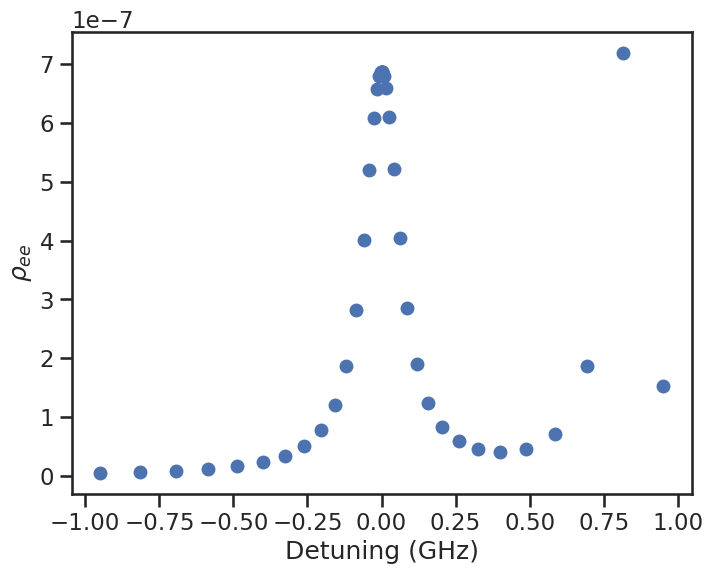

In [48]:
excited_state_pops_steady_state = [sum(state.diag()[8:]).real for state in laser_ss_list]
plt.plot(laser_detunings/2e9/pi, excited_state_pops_steady_state, "o")
plt.xlabel("Detuning (GHz)")
plt.ylabel(r"$\rho_{ee}$")


In [37]:
import ipyparallel as ipp
nr_cores = 14
cluster = ipp.Cluster(n=nr_cores)
cluster.start_cluster_sync()
rc = cluster.connect_client_sync()
rc.wait_for_engines(nr_cores)
rc.ids
dview = rc[:]

from sim import run_simulation

parallel_result = dview.map_sync(run_simulation, parallel_fun_input)

save_dir = (
    Path(".")
    / "results"
    / ("sim_" + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
)
# save_dir.mkdir(parents=True)
# qsave(parallel_result, save_dir / "results_list")
# qsave(hs, save_dir / "hamiltonians")
# qsave(decays, save_dir / "decays")
# import pandas as pd
# params_df = pd.DataFrame(parameters)
# params_df.to_csv(save_dir / "parameters.csv")

Starting 14 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1667314546-z34l:Starting 14 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


100%|██████████| 14/14 [00:07<00:00,  1.85engine/s]


# doppler

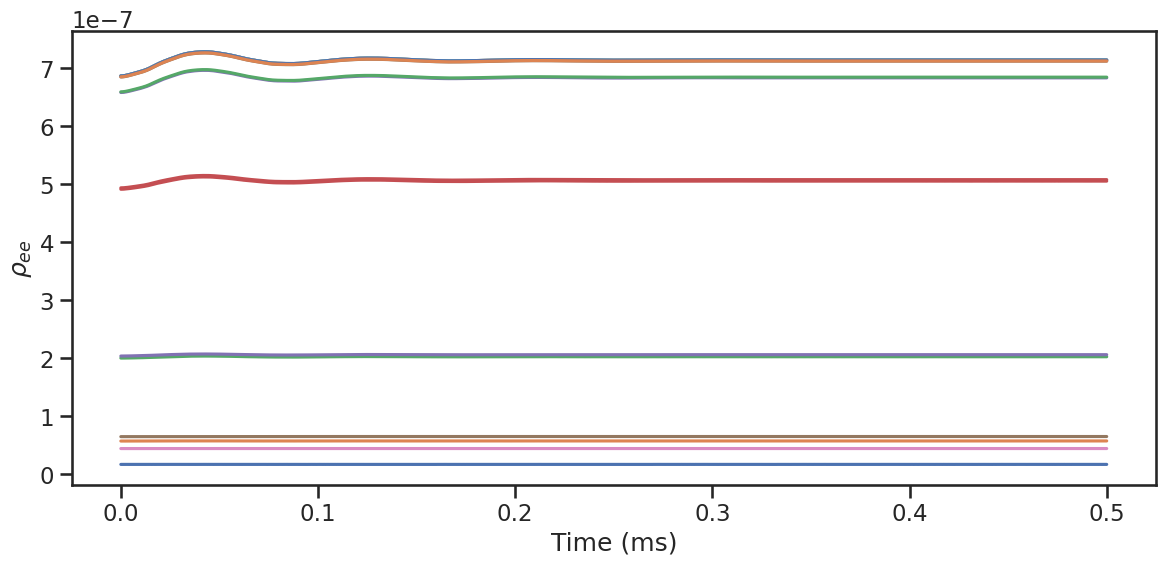

In [93]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(d.times*1e3, [sum(state.diag()[8:]).real for state in d.states], label=fr"${det/2e6/pi:.1f}$")
  
ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()
# %%


In [124]:
weighted = [sum([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]

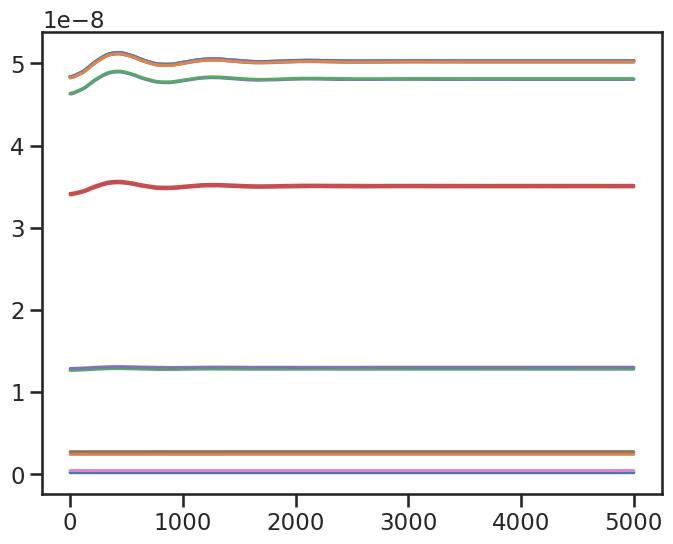

In [123]:
plt.plot([([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))])

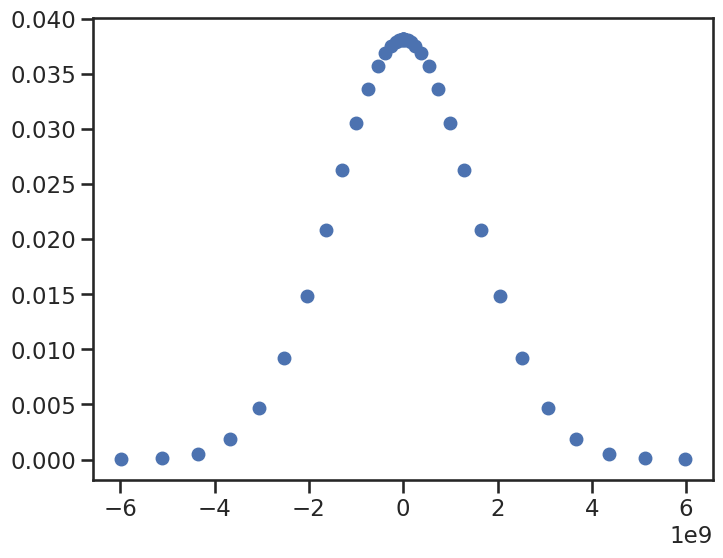

In [49]:
plt.plot(laser_detunings, [norm_dist(det)/sum(norm_dist(laser_detunings)) for det in laser_detunings], "o")

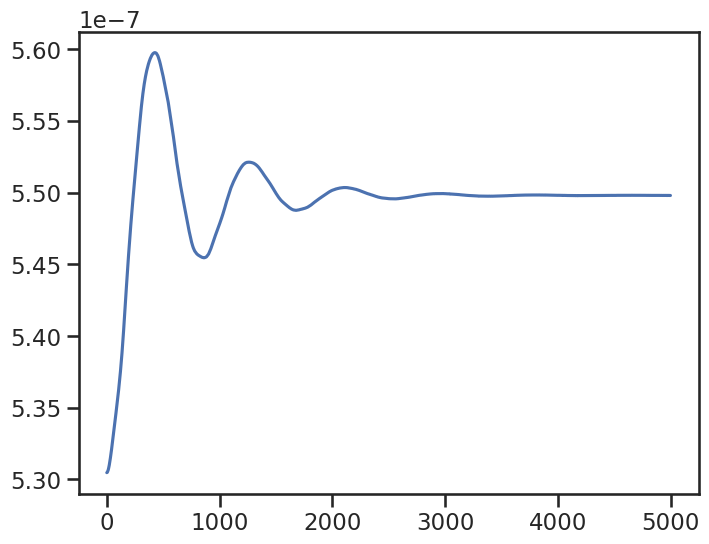

In [126]:
plt.plot(weighted)

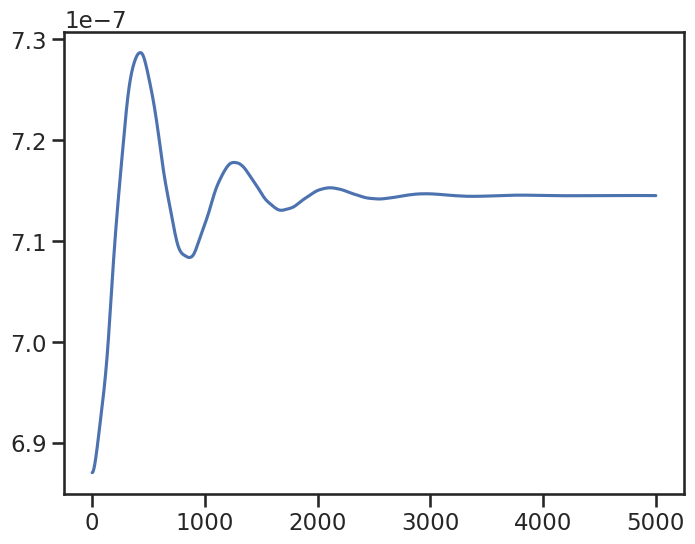

In [127]:
plt.plot([sum(state.diag()[8:]).real for state in  parallel_result[8].states])

# more points

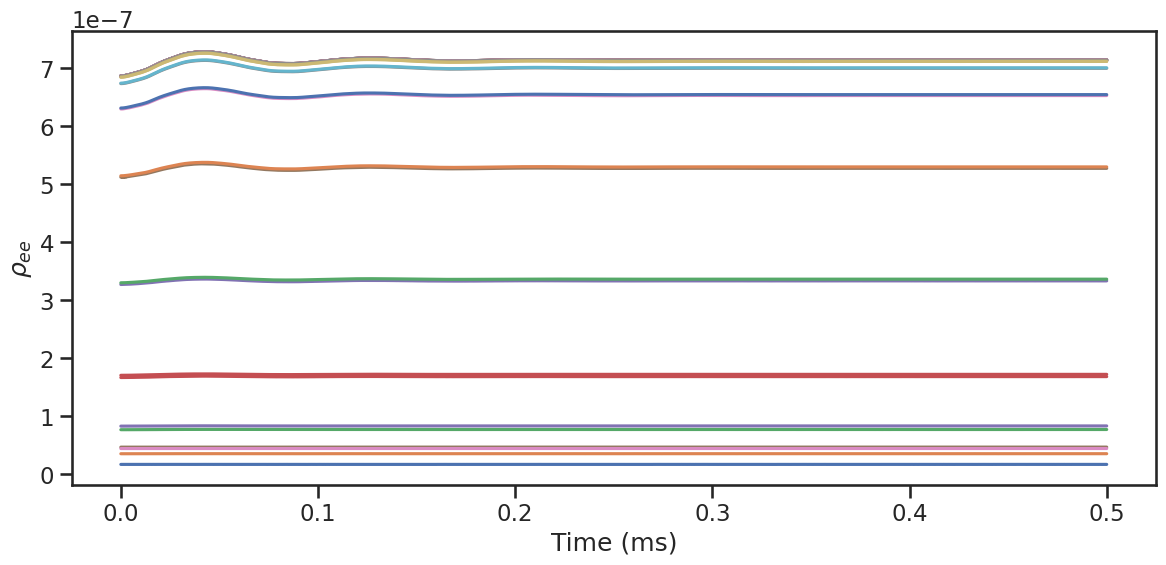

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(d.times*1e3, [sum(state.diag()[8:]).real for state in d.states], label=fr"${det/2e6/pi:.1f}$")
  
ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()
# %%


In [17]:
def norm_dist(det):
    sigma = doppler_FWHM/(2*np.log(2))**0.5 / 2
    return 1/(sigma * (2*pi)**0.5) * np.exp(-0.5 * (det/sigma)**2)

In [18]:
weighted = [sum([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]

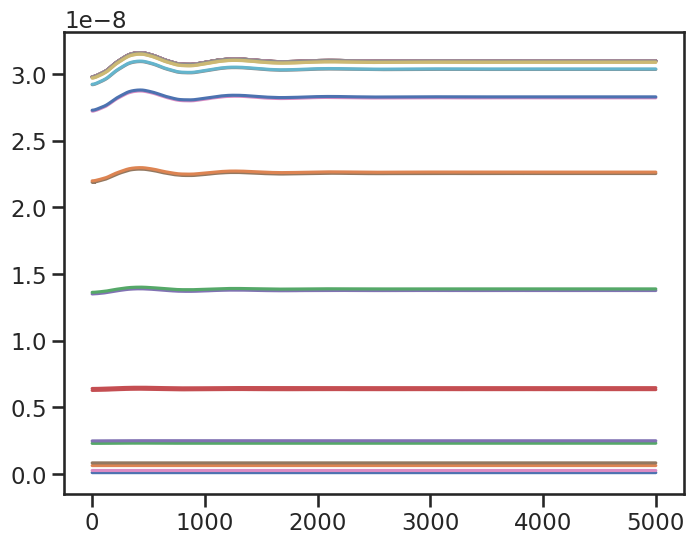

In [19]:
plt.plot([([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))])

In [20]:
laser_detunings/2e6/pi

array([-4.75620208e+02, -3.18749687e+02, -2.06303674e+02, -1.28098350e+02,
       -7.56407949e+01, -4.19752675e+01, -2.15294898e+01, -9.96092773e+00,
       -4.00307345e+00, -1.31172711e+00, -3.11278991e-01, -4.09914721e-02,
       -1.28098350e-03,  0.00000000e+00,  1.28098350e-03,  4.09914721e-02,
        3.11278991e-01,  1.31172711e+00,  4.00307345e+00,  9.96092773e+00,
        2.15294898e+01,  4.19752675e+01,  7.56407949e+01,  1.28098350e+02,
        2.06303674e+02,  3.18749687e+02,  4.75620208e+02])

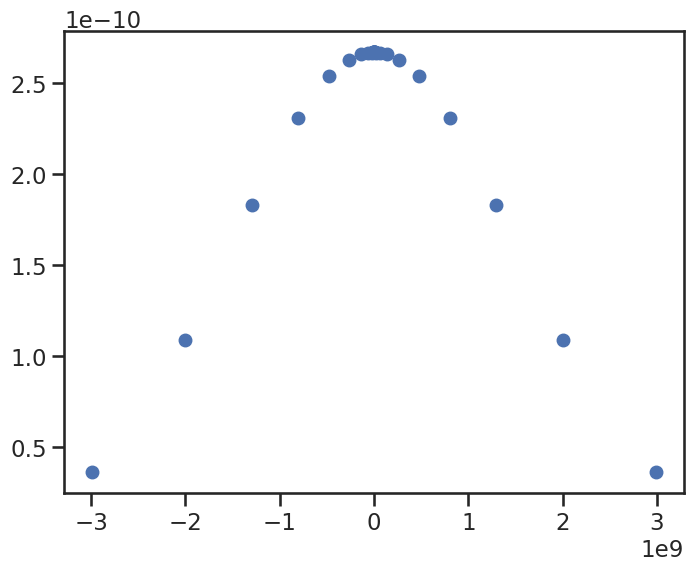

In [21]:
plt.plot(laser_detunings, [norm_dist(det) for det in laser_detunings], "o")

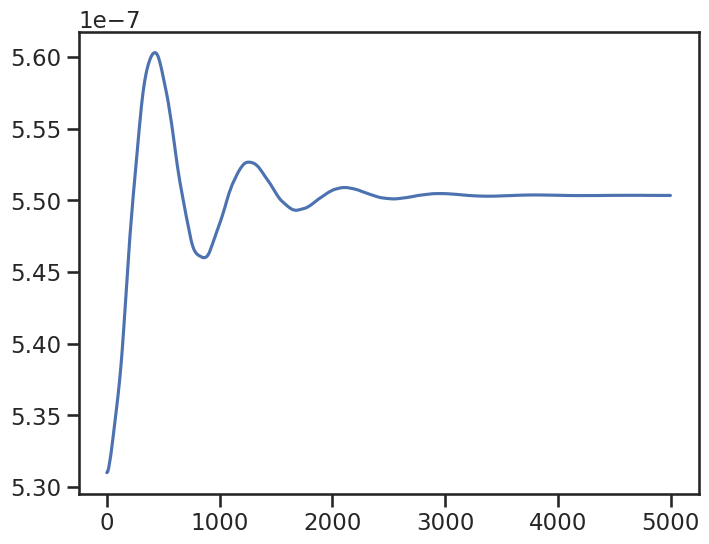

In [22]:
plt.plot(weighted)

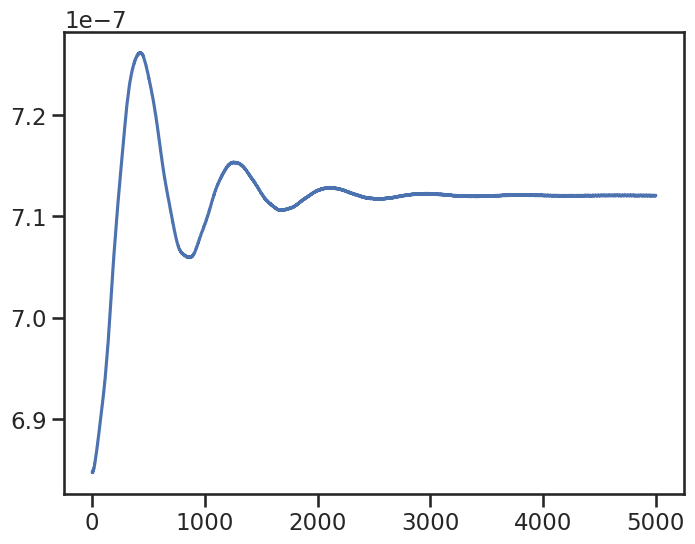

In [23]:
plt.plot([sum(state.diag()[8:]).real for state in  parallel_result[8].states])

# double doppler broadening

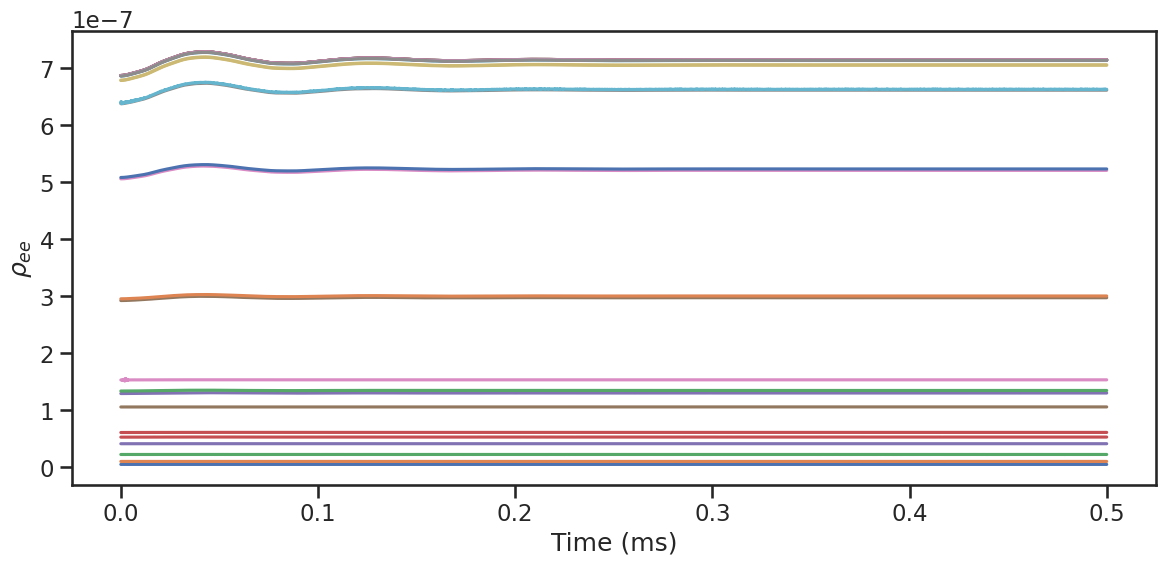

In [25]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(d.times*1e3, [sum(state.diag()[8:]).real for state in d.states], label=fr"${det/2e6/pi:.1f}$")
  
ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()
# %%


In [26]:
def norm_dist(det):
    sigma = doppler_FWHM/(2*np.log(2))**0.5 / 2
    return 1/(sigma * (2*pi)**0.5) * np.exp(-0.5 * (det/sigma)**2)

In [27]:
weighted = [sum([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]

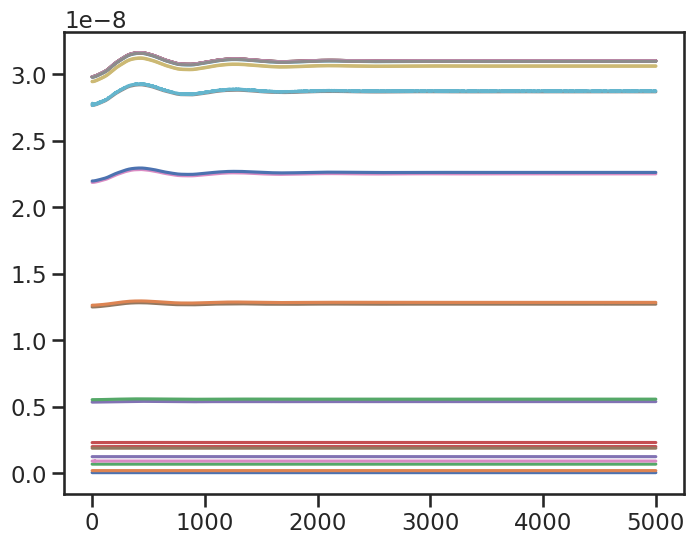

In [28]:
plt.plot([([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))])

In [29]:
laser_detunings/2e6/pi

array([-9.51240416e+02, -6.37499375e+02, -4.12607349e+02, -2.56196701e+02,
       -1.51281590e+02, -8.39505349e+01, -4.30589795e+01, -1.99218555e+01,
       -8.00614690e+00, -2.62345422e+00, -6.22557983e-01, -8.19829443e-02,
       -2.56196701e-03,  0.00000000e+00,  2.56196701e-03,  8.19829443e-02,
        6.22557983e-01,  2.62345422e+00,  8.00614690e+00,  1.99218555e+01,
        4.30589795e+01,  8.39505349e+01,  1.51281590e+02,  2.56196701e+02,
        4.12607349e+02,  6.37499375e+02,  9.51240416e+02])

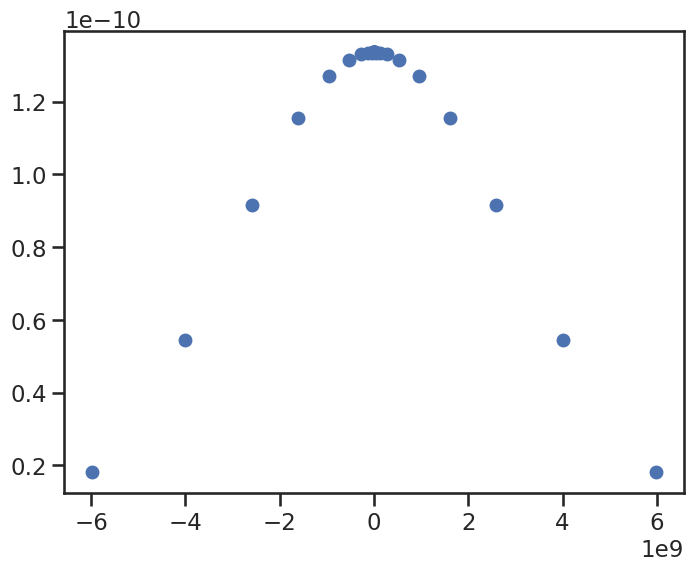

In [30]:
plt.plot(laser_detunings, [norm_dist(det) for det in laser_detunings], "o")

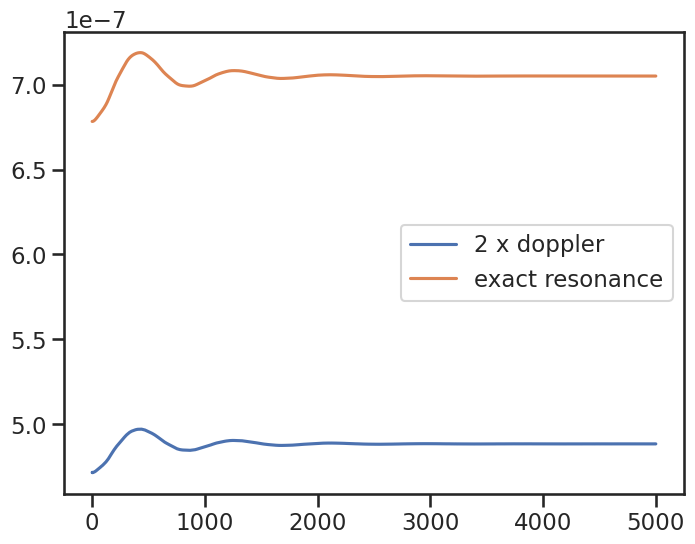

In [36]:
plt.plot(weighted, label="2 x doppler")
plt.plot([sum(state.diag()[8:]).real for state in  parallel_result[8].states], label="exact resonance")
plt.legend()

# four times doppler broadening

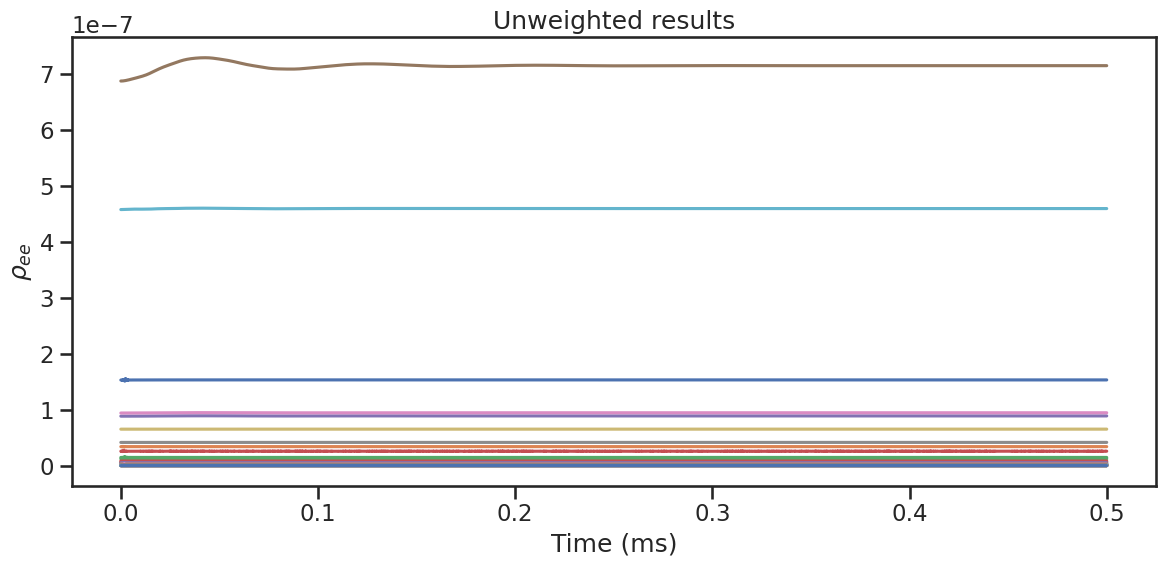

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(d.times*1e3, [sum(state.diag()[8:]).real for state in d.states], label=fr"${det/2e6/pi:.1f}$")
  
ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
ax.set_title("Unweighted results")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()
# %%


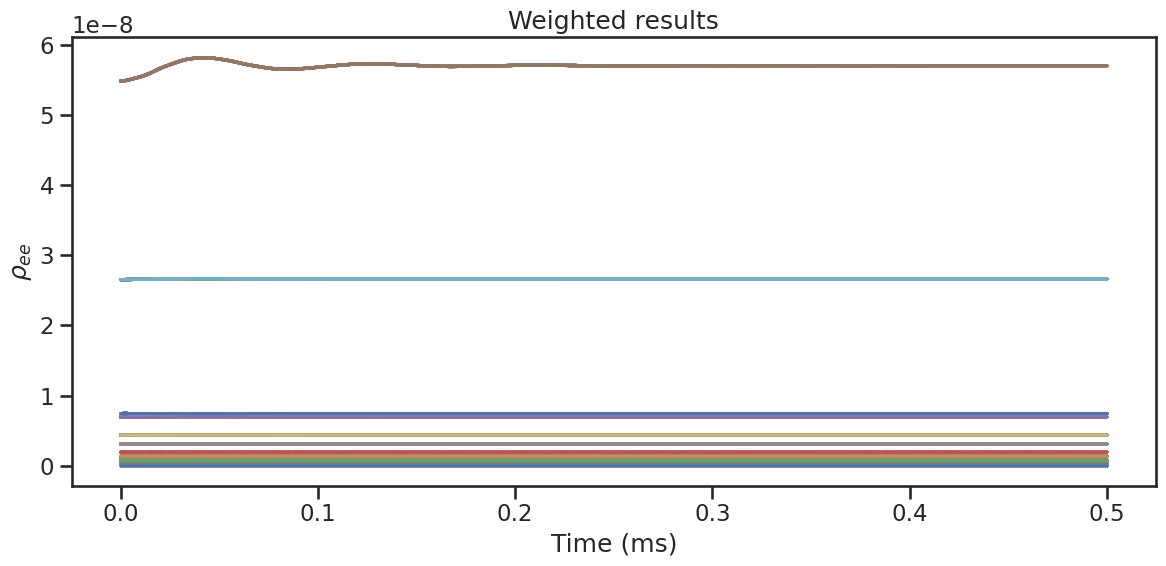

In [45]:
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(
       d.times*1e3, 
       [
           ([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) 
           for n in range(len(parallel_result[0].times))
       ], 
       label=fr"${det/2e6/pi:.1f}$"
    )
ax.set_title("Weighted results")

ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()


In [41]:
laser_detunings/2e6/pi

array([-4756.20208161, -4565.95399835, -4375.70591508, -4185.45783182,
       -3995.20974855, -3804.96166529, -3614.71358203, -3424.46549876,
       -3234.2174155 , -3043.96933223, -2853.72124897, -2663.4731657 ,
       -2473.22508244, -2282.97699917, -2092.72891591, -1902.48083265,
       -1712.23274938, -1521.98466612, -1331.73658285, -1141.48849959,
        -951.24041632,  -760.99233306,  -570.74424979,  -380.49616653,
        -190.24808326,     0.        ,   190.24808326,   380.49616653,
         570.74424979,   760.99233306,   951.24041632,  1141.48849959,
        1331.73658285,  1521.98466612,  1712.23274938,  1902.48083265,
        2092.72891591,  2282.97699917,  2473.22508244,  2663.4731657 ,
        2853.72124897,  3043.96933223,  3234.2174155 ,  3424.46549876,
        3614.71358203,  3804.96166529,  3995.20974855,  4185.45783182,
        4375.70591508,  4565.95399835,  4756.20208161])

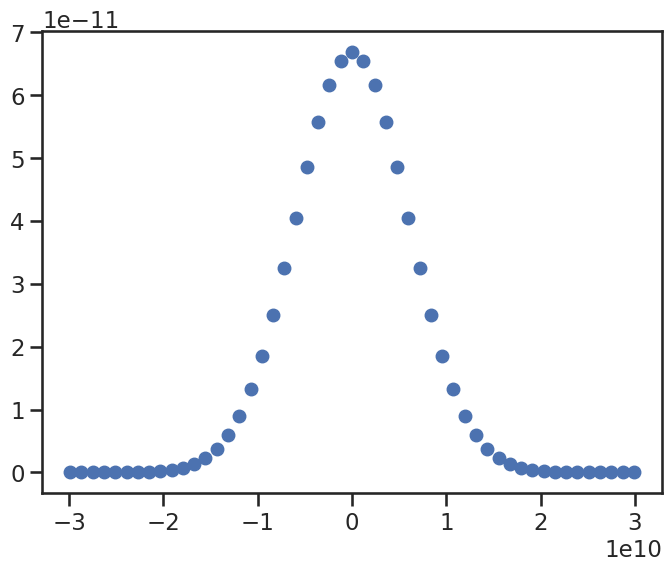

In [42]:
plt.plot(laser_detunings, [norm_dist(det) for det in laser_detunings], "o")

In [39]:
weighted = [sum([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]

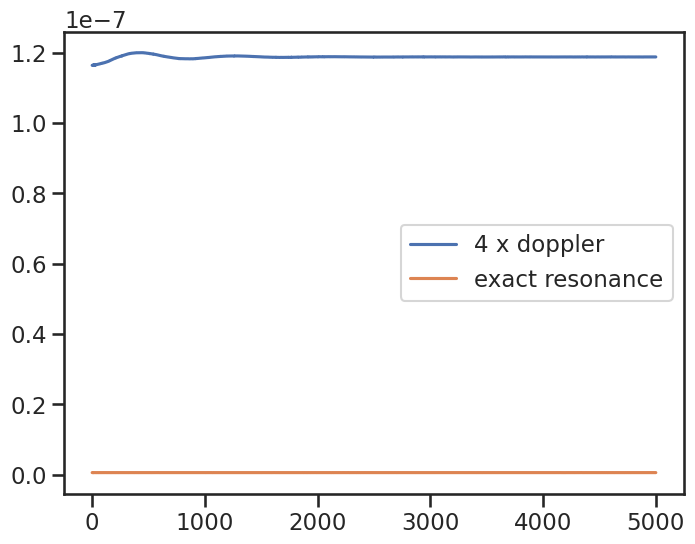

In [43]:
plt.plot(weighted, label="4 x doppler")
plt.plot([sum(state.diag()[8:]).real for state in  parallel_result[8].states], label="exact resonance")
plt.legend()

# correct Doppler again

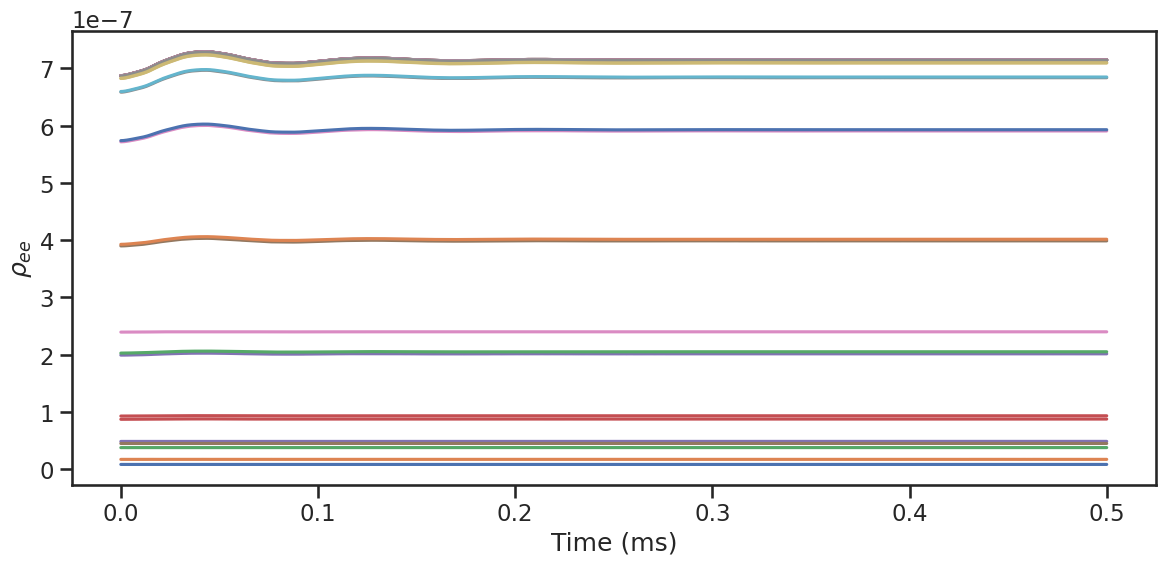

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(d.times*1e3, [sum(state.diag()[8:]).real for state in d.states], label=fr"${det/2e6/pi:.1f}$")
  
ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()
# %%


In [13]:
weighted = [sum([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]

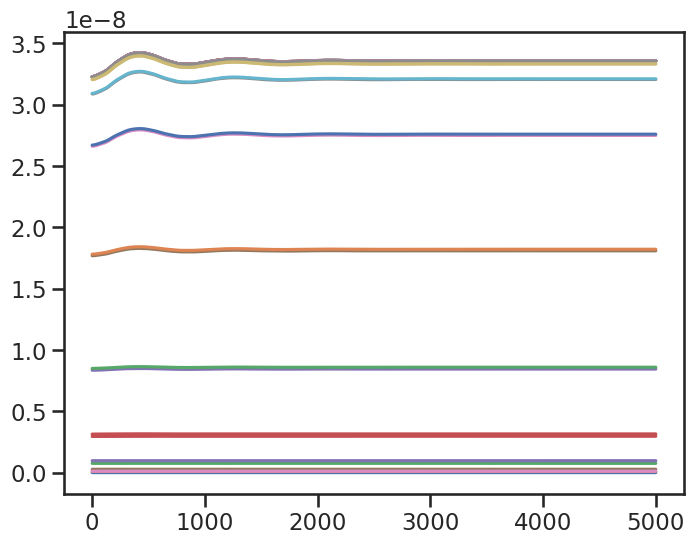

In [14]:
plt.plot([([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]);

In [15]:
laser_detunings/2e6/pi

array([-7.13430312e+02, -4.78124531e+02, -3.09455511e+02, -1.92147526e+02,
       -1.13461192e+02, -6.29629012e+01, -3.22942346e+01, -1.49413916e+01,
       -6.00461018e+00, -1.96759066e+00, -4.66918487e-01, -6.14872082e-02,
       -1.92147526e-03,  0.00000000e+00,  1.92147526e-03,  6.14872082e-02,
        4.66918487e-01,  1.96759066e+00,  6.00461018e+00,  1.49413916e+01,
        3.22942346e+01,  6.29629012e+01,  1.13461192e+02,  1.92147526e+02,
        3.09455511e+02,  4.78124531e+02,  7.13430312e+02])

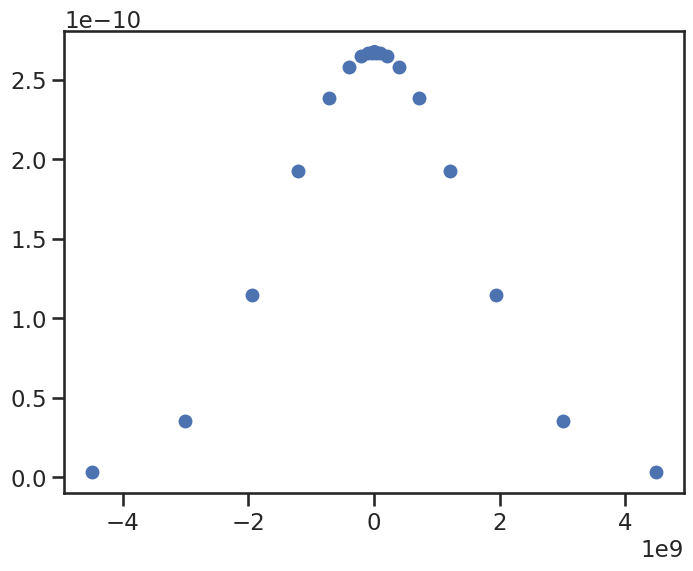

In [16]:
plt.plot(laser_detunings, [norm_dist(det) for det in laser_detunings], "o")

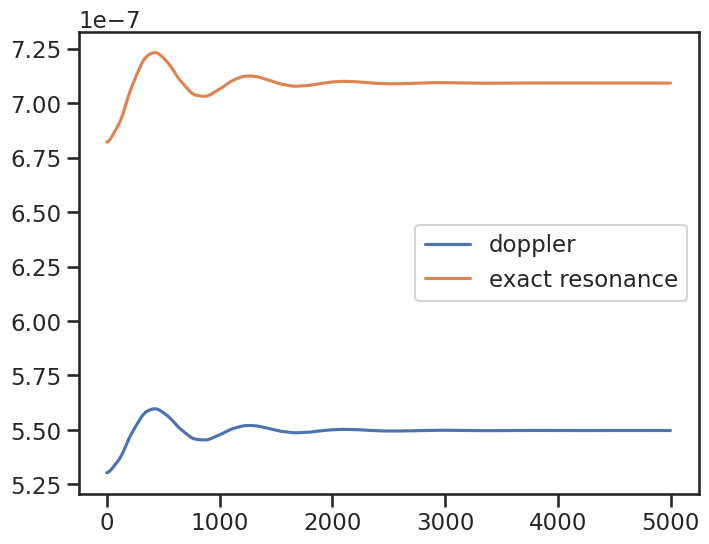

In [17]:
plt.plot(weighted, label="doppler")
plt.plot([sum(state.diag()[8:]).real for state in  parallel_result[8].states], label="exact resonance")
plt.legend()

# wider range, same Doppler 

In [73]:
laser_detunings

array([-5.97681981e+09, -5.12437588e+09, -4.35710164e+09, -3.67051446e+09,
       -3.06013174e+09, -2.52147086e+09, -2.05004919e+09, -1.64138414e+09,
       -1.29099308e+09, -9.94393395e+08, -7.47102476e+08, -5.44637705e+08,
       -3.82516468e+08, -2.56256149e+08, -1.61374135e+08, -9.33878095e+07,
       -4.78145585e+07, -2.01717669e+07, -5.97681981e+06, -7.47102476e+05,
        0.00000000e+00,  7.47102476e+05,  5.97681981e+06,  2.01717669e+07,
        4.78145585e+07,  9.33878095e+07,  1.61374135e+08,  2.56256149e+08,
        3.82516468e+08,  5.44637705e+08,  7.47102476e+08,  9.94393395e+08,
        1.29099308e+09,  1.64138414e+09,  2.05004919e+09,  2.52147086e+09,
        3.06013174e+09,  3.67051446e+09,  4.35710164e+09,  5.12437588e+09,
        5.97681981e+09])

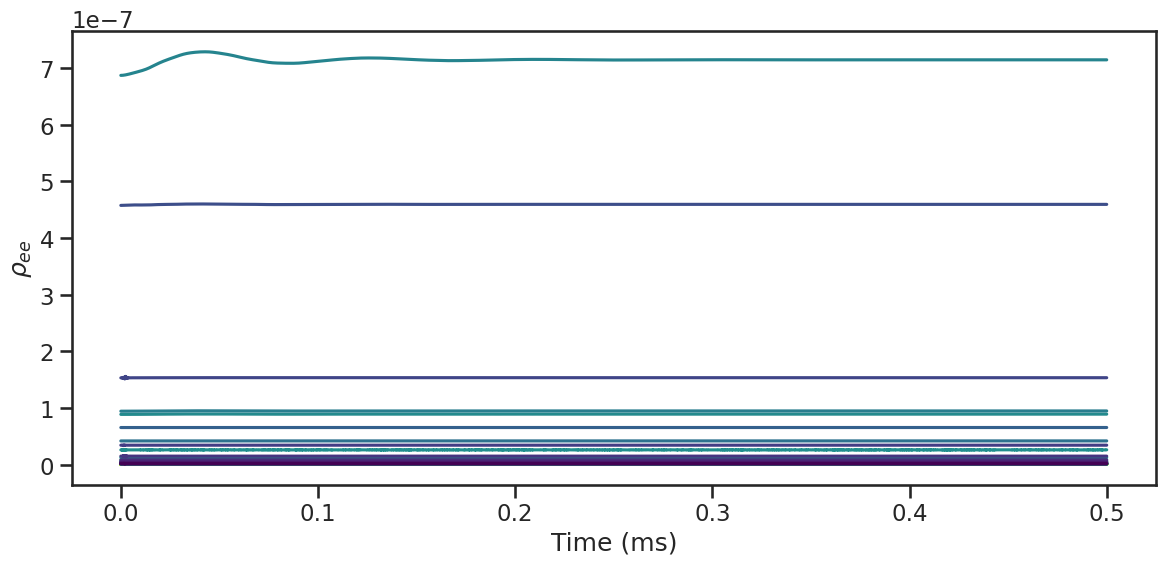

In [75]:
from matplotlib import cm
import matplotlib as mpl
norm = mpl.colors.SymLogNorm(linthresh=9e8)
norm.autoscale(laser_detunings)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_style("ticks")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
    y = [sum(state.diag()[8:]).real for state in d.states]
    ax.plot(d.times*1e3, y, color=cm.viridis_r(norm(det)), label=fr"${det/2e6/pi:.1f}$")
ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()
# %%


In [22]:
weighted = [sum([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) for n in range(len(parallel_result[0].times))]

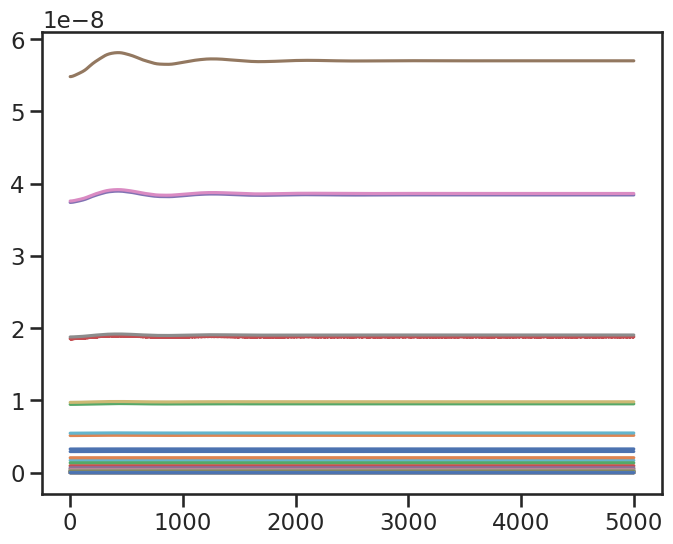

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
for det, d in zip(laser_detunings, parallel_result):
        # endval = sum(d.states[-1].diag()[8:]).real
   ax.plot(
       d.times*1e3, 
       [
           ([norm_dist(det) * sum(res.states[n].diag()[8:]).real/sum(norm_dist(laser_detunings)) for det, res in zip(laser_detunings, parallel_result)]) 
           for n in range(len(parallel_result[0].times))
       ], 
       label=fr"${det/2e6/pi:.1f}$"
    )
ax.set_title("Weighted results")

ax.set_ylabel(r"$\rho_{ee}$")
ax.set_xlabel("Time (ms)")
    # sns.despine()
# plt.legend(loc=(1.03, 0.25),  title=fr"Laser Detuning [MHz]")
plt.tight_layout()


In [24]:
laser_detunings/2e6/pi

array([-1189.0505204 , -1141.48849959, -1093.92647877, -1046.36445795,
        -998.80243714,  -951.24041632,  -903.67839551,  -856.11637469,
        -808.55435387,  -760.99233306,  -713.43031224,  -665.86829143,
        -618.30627061,  -570.74424979,  -523.18222898,  -475.62020816,
        -428.05818735,  -380.49616653,  -332.93414571,  -285.3721249 ,
        -237.81010408,  -190.24808326,  -142.68606245,   -95.12404163,
         -47.56202082,     0.        ,    47.56202082,    95.12404163,
         142.68606245,   190.24808326,   237.81010408,   285.3721249 ,
         332.93414571,   380.49616653,   428.05818735,   475.62020816,
         523.18222898,   570.74424979,   618.30627061,   665.86829143,
         713.43031224,   760.99233306,   808.55435387,   856.11637469,
         903.67839551,   951.24041632,   998.80243714,  1046.36445795,
        1093.92647877,  1141.48849959,  1189.0505204 ])

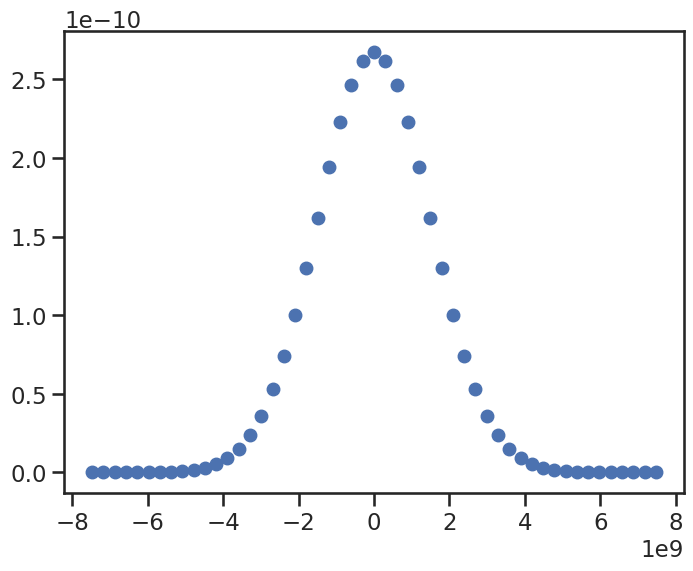

In [25]:
plt.plot(laser_detunings, [norm_dist(det) for det in laser_detunings], "o")

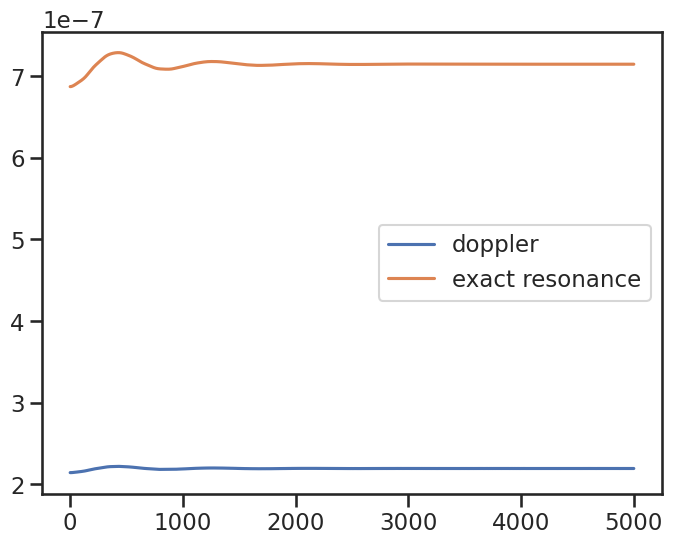

In [27]:
plt.plot(weighted, label="doppler")
plt.plot([sum(state.diag()[8:]).real for state in  parallel_result[len(parallel_result)//2].states], label="exact resonance")
plt.legend()

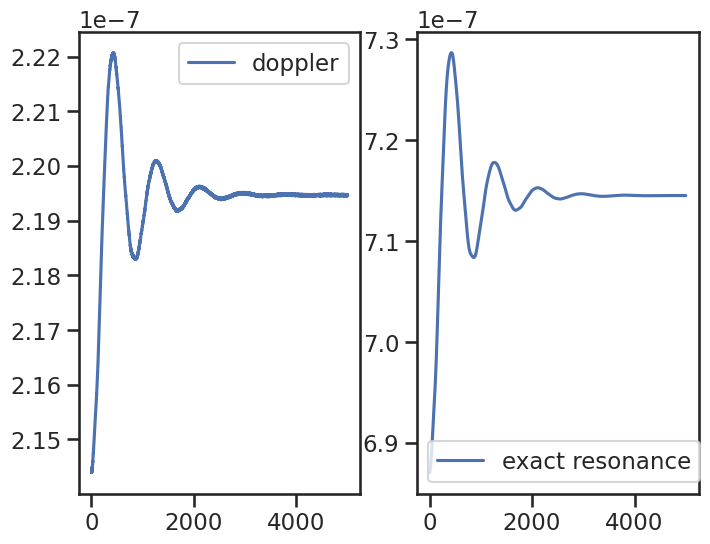

In [31]:
fig, (ax1,ax2) = plt.subplots(ncols=2)
ax1.plot(weighted, label="doppler")
ax2.plot([sum(state.diag()[8:]).real for state in  parallel_result[len(parallel_result)//2].states], label="exact resonance")
ax1.legend()
ax2.legend()

In [5]:
# results_list = qload(r"sim_2022_11_01_14_55_39_laser_detunings_doppler\results_list")

In [6]:
from genobs.faraday import faraday_rot_angle

In [11]:
angles = [faraday_rot_angle(rho, -30e9*2*pi) for rho in results_list[13].states]

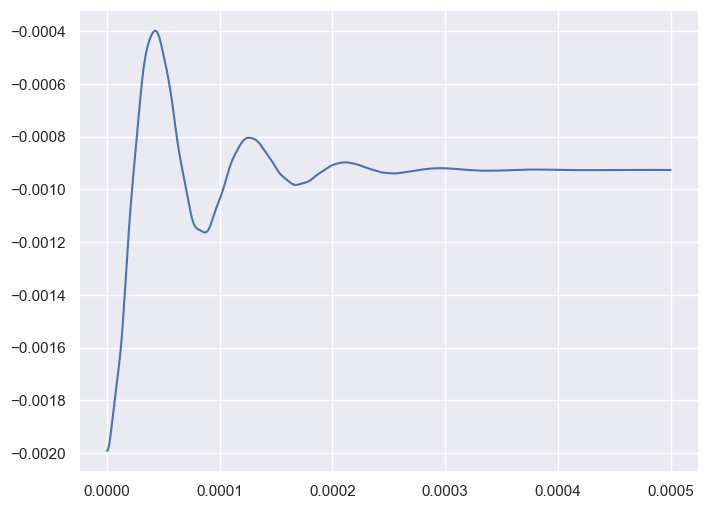

In [12]:
plt.plot(results_list[13].times, angles)